<a href="https://colab.research.google.com/github/mksachs/CCVC/blob/main/notebooks/Unit%203%20-%20Vision%20Transformers/KnowledgeDistillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Distillation with Vision Tranformers - Example

Now we will apply Knowledge Distillation techniques to the [oxford-pets](https://huggingface.co/datasets/pcuenq/oxford-pets) dataset, a datset with *37 classes of dogs and cats*.

We'll begin by importing the required libraries:

In [46]:
!pip install -U -q datasets evaluate

In [47]:
from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification, ViTConfig, ViTForImageClassification
from transformers import ViTImageProcessor, ViTConfig, ViTForImageClassification
from transformers import TrainingArguments, Trainer
import evaluate

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

from PIL import Image
import io

We will be distilling the knowledge from ```asusevski/vit-base-patch16-224-oxford-pets```, a fine-tuned model based on ```google/vit-base-patch16-224``` into a randomized ```WinKawaks/vit-tiny-patch16-224``` model. Note that the fine-tuned ViT model that will be our teacher model was trained on this dataset already, achieving about **93%** accuracy!

First, lets see the teacher in action:

In [48]:
dataset = load_dataset("pcuenq/oxford-pets")

In [49]:
id2label = {int_label: str_label for int_label, str_label in enumerate(sorted(list(set(dataset['train']['label']))))}
label2id = {str_label: int_label for int_label, str_label in enumerate(sorted(list(set(dataset['train']['label']))))}

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
teacher_model_name = "asusevski/vit-base-patch16-224-oxford-pets"
teacher_model = AutoModelForImageClassification.from_pretrained(teacher_model_name).to(device)
teacher_model.eval()
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
accuracy = evaluate.load("accuracy")

In [51]:
processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

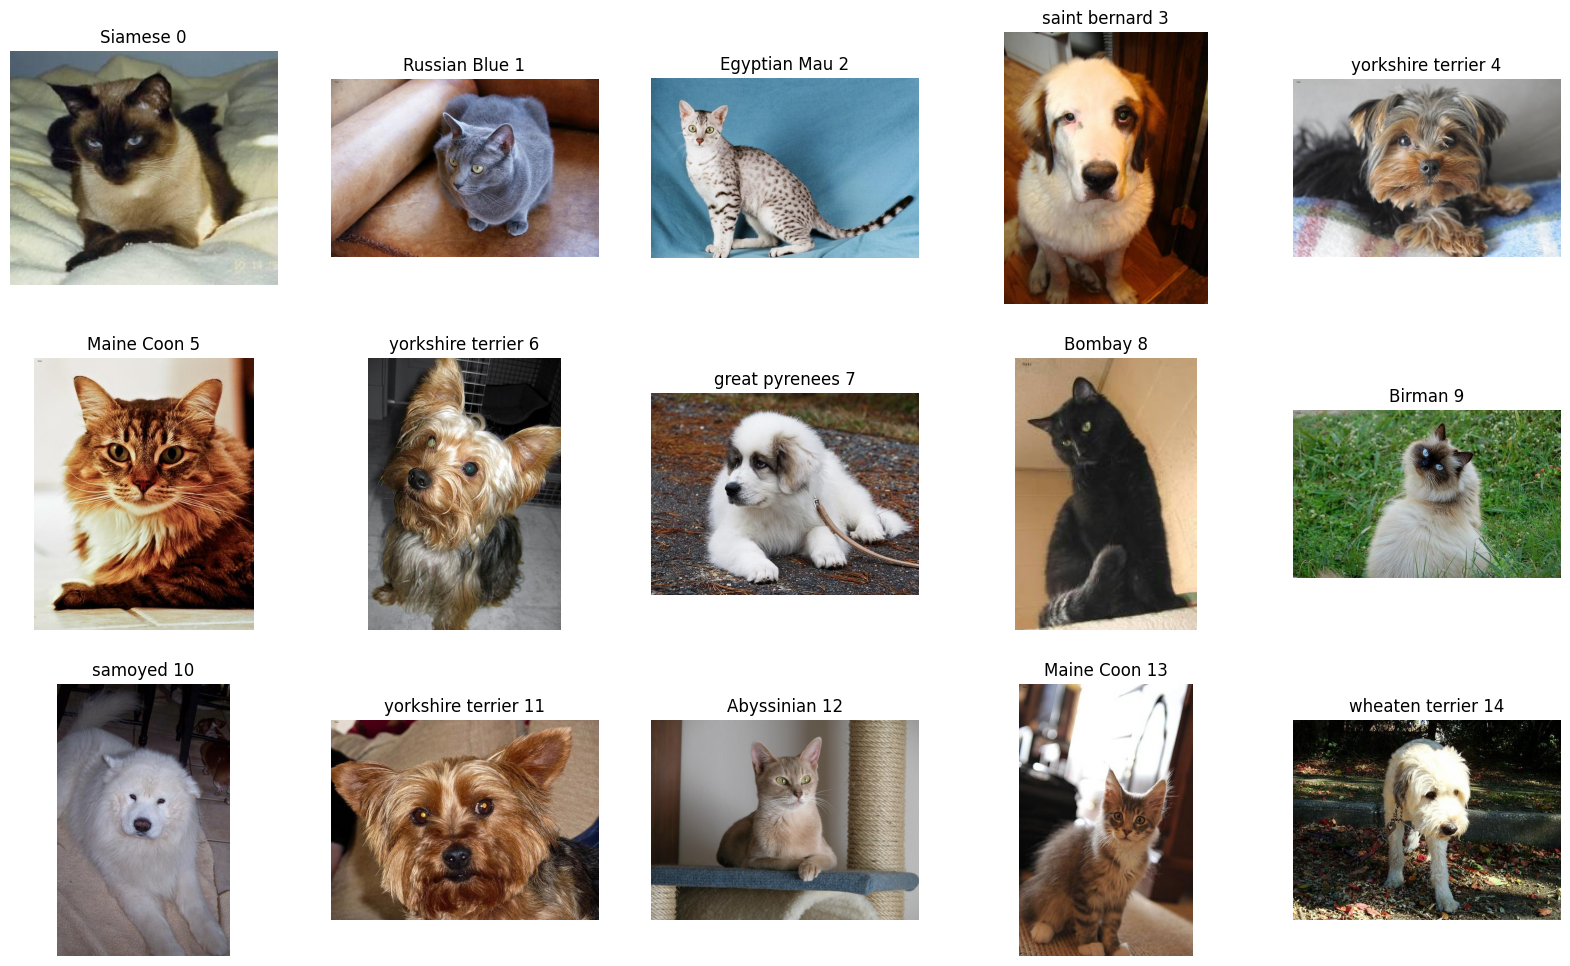

In [53]:
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows*cols):
        img_bytes = samples[i]['image']['bytes']
        img = Image.open(io.BytesIO(img_bytes))
        label = samples[i]['label']
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(f"{label} {i}")
        plt.axis('off')

show_samples(dataset['train'],rows=3,cols=5)

In [54]:
def transforms(batch):
    batch['image'] = [Image.open(io.BytesIO(x['bytes'])).convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'],return_tensors='pt')
    inputs['labels']=[label2id[y] for y in batch['label']]
    return inputs

processed_dataset = dataset.with_transform(transforms)

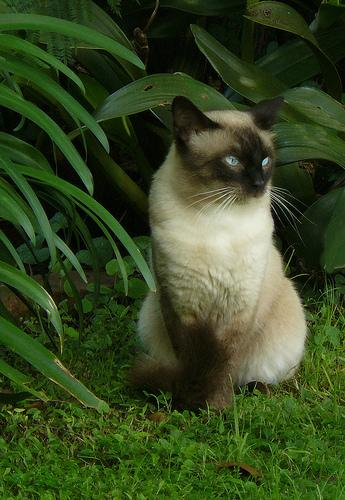

In [55]:
Image.open(io.BytesIO(dataset["train"][0]["image"]['bytes'])).convert('RGB')

In [56]:
inputs = processor(Image.open(io.BytesIO(dataset["train"][0]["image"]['bytes'])).convert('RGB'), return_tensors="pt") # Here, using default processor on the image
inputs = {key: value.to(device) for key, value in inputs.items()} # Converting to a dictionary
model_logits = teacher_model(**inputs).logits
model_prediction = torch.argmax(model_logits, dim=1).item()
print(id2label[model_prediction])

Siamese


The model was able to infer that this was a Siamese cat, and a stunning one at that.

This is a great time to dive into *how* we will be using the teacher model's prior knowedge to teach a student model with knowledge distillation.

What we're doing when we perform Knowledge Distillation is, for a given image, trying to get the student model's distribution to mimic that of the Teacher's distribution over all the classes.

Some of the key terms you will encounter are:
- ```temperature```
- ```KL Divergence```
- ```lambda parameter```

Lets start by explaining ```temperature```.

**Temperature** is a hyperparameter that controls the importance of each soft target. Soft target is a term for the teachers' distribution over the output classes, since they are precisely what our student wants to *approach*. A larger temperature will result in a higher loss, thus penalizing the student model further.

Lets look at the teacher's distribution over the classes and then modify the distribution with 2 examples:
- a "low" temperature of 2
- a "high" temperature of 8.

In [57]:
teacher_distribution = F.softmax(model_logits / 1, dim=-1).cpu().detach().numpy()
teacher_distribution.reshape(-1).shape

(37,)

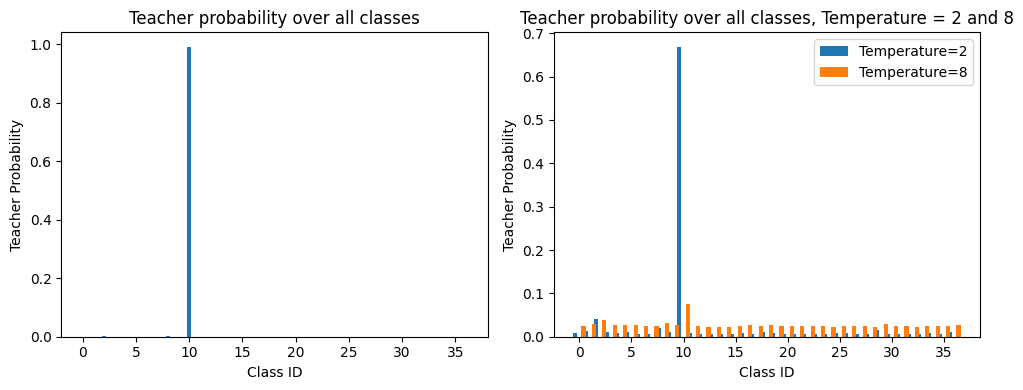

In [58]:
temperature_no_change = 1
low_temperature = 2
high_temperature = 8

teacher_distribution = F.softmax(model_logits / temperature_no_change, dim=-1).cpu().detach().numpy().reshape(-1)
teacher_distribution_low_temp = F.softmax(model_logits / low_temperature, dim=-1).cpu().detach().numpy().reshape(-1)
teacher_distribution_high_temp = F.softmax(model_logits / high_temperature, dim=-1).cpu().detach().numpy().reshape(-1)


fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].bar(id2label.keys(), teacher_distribution, width = 0.4)
axs[0].set_title("Teacher probability over all classes")
axs[0].set_ylabel('Teacher Probability')
axs[0].set_xlabel("Class ID")

axs[1].bar(np.fromiter(id2label.keys(), dtype=float) - 0.4, teacher_distribution_low_temp, width = 0.4, label='Temperature=2')
axs[1].bar(np.fromiter(id2label.keys(), dtype=float) + 0.4, teacher_distribution_high_temp, width = 0.4, label='Temperature=8')
axs[1].set_title("Teacher probability over all classes, Temperature = 2 and 8")
axs[1].set_ylabel('Teacher Probability')
axs[1].set_xlabel("Class ID")
axs[1].legend()
plt.tight_layout()
plt.show()

As we can see, a higher temperature sort of smoothes out the distribution, making the probabilities easier to learn from.

Next, we have ```KL Divergence```.

**KL Divergence** is a measure of how similar/dissimilar two probability distributions are. It quantifies how much information is lost when one distribution (our student) is used to approximate the other. If it is 0, then in the case of knowledge distillation, that would mean the student has nothing left to learn from the teacher.

Finally, we have the ```lambda parameter```.

**Lambda parameter** is a weight applied to the overall loss functions terms. There are two terms -- the distillation loss (which comes from the KL-Divergence, as discussed above), and the students' own loss on the dataset. We take a linear combination of these terms, weighted by lambda, and that is our overall loss.

Now we have to prepare the data for ingestion by the HuggingFace Trainer. We prepared the inputs by using the ```ViTImageProcessor``` class above, but we also need to preprare the labels for training. These transforms will be written in the function ```transforms``` and we will map the transforms to each observation in the dataset.

In [69]:
dataset['train'][0]['image']

{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\xf4\x01Y\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca\x

In [70]:
def transforms(example):
    # Convert to RGB - there are some example in the Oxford Pets dataset that are RGBA, and even at least one gif
    # example['image'] = example['image'].convert('RGB')
    example['image'] = Image.open(io.BytesIO(example["image"]['bytes'])).convert('RGB')

    # Feed image into ViT image processor
    inputs = processor(example['image'], return_tensors='pt')

    # Add to example
    example['pixel_values'] = inputs['pixel_values'].squeeze()
    example['label'] = label2id[example['label']]
    return example

In [71]:
transformed_dataset = dataset.map(transforms)
transformed_dataset.set_format("pt", columns=["pixel_values"], output_all_columns=True)

Map:   0%|          | 0/7390 [00:00<?, ? examples/s]

In [72]:
def collate_fn(batch):
    return {
        'pixel_values': torch.cat([x['pixel_values'].unsqueeze(dim=0) for x in batch], dim=0),
        'labels': torch.tensor([x['label'] for x in batch])
    }

Splitting the dataset into train, validation, and test sets:

In [73]:
train_test_dataset = transformed_dataset['train'].train_test_split(test_size=0.2)
train_val_dataset = train_test_dataset['train'].train_test_split(test_size=(0.1/0.8))
train_test_valid_dataset = DatasetDict({
    'train': train_val_dataset['train'],
    'valid': train_val_dataset['test'],
    'test': train_test_dataset['test']
})

First, as a baseline model, we'll fine-tune ```WinKawaks/vit-tiny-patch16-224``` for 5 epochs on the same training data to get an idea of what the performance would look like!

For this, we'll rely on HuggingFace's Trainer API. We need
1. Our base model
2. ```Training Arguments```
3. A compute_metrics function
4. Our final ```Trainer``` object

Initializing a randomized ```WinKawaks/vit-tiny-patch16-224``` model here, we only need to pass a ```ViTConfig``` object to the ```ViTForImageClassification``` class. We'll also modify the config for our specific use-case by adding the number of labels required (so the classifier head is appropriately configued) and the mappings from ids to labels.

In [74]:
config = ViTForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224").config
config.id2label = id2label
config.label2id = label2id
config.num_labels=len(id2label)
base_model = ViTForImageClassification(config).to(device)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Next, we'll configure our arguments. Here is where we will also push our fine-tuned model to the HuggingFace Hub (we have to log in first)

In [75]:
from huggingface_hub import notebook_login

notebook_login()

In [76]:
training_args = TrainingArguments(
    output_dir="oxford-pets-vit-from-scratch",
    per_device_train_batch_size=48,
    per_device_eval_batch_size=48,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=10,
    learning_rate=3e-4,
    push_to_hub=True,
    load_best_model_at_end=True,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Defining our compute metrics function -- we'll leave it at just accuracy for the purposes of this demo, but you can add others if you so choose. We'll re-use this later for when we train a model through Knowledge Distillation.

In [77]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    acc = accuracy.compute(references=labels, predictions=np.argmax(predictions, axis=1))
    return {"accuracy": acc["accuracy"]}

And finally our ```Trainer``` object!

In [79]:
trainer = Trainer(
    model=base_model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_test_valid_dataset["train"],
    eval_dataset=train_test_valid_dataset["test"],
    processing_class=processor
)

Now for the most satisfying part of any HuggingFace Project -- calling ```trainer.train()```

In [80]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mksachs (mksachs-mikesachs-com) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,3.623200,3.562719,0.045332
2,3.542700,3.511195,0.053451
3,3.488600,3.483104,0.061570
4,3.437100,3.402711,0.082544
5,3.359200,3.361543,0.094723
6,3.311800,3.319607,0.104195
7,3.225600,3.308577,0.106225
8,3.194000,3.259840,0.110284
9,3.117500,3.250851,0.118403
10,3.061900,3.222534,0.127199


TrainOutput(global_step=1080, training_loss=3.3138178931342233, metrics={'train_runtime': 1175.0035, 'train_samples_per_second': 44.025, 'train_steps_per_second': 0.919, 'total_flos': 2.5843921435035648e+17, 'train_loss': 3.3138178931342233, 'epoch': 10.0})

In [81]:
trainer.evaluate(train_test_valid_dataset["test"])

{'eval_loss': 3.222533702850342,
 'eval_accuracy': 0.12719891745602166,
 'eval_runtime': 19.6991,
 'eval_samples_per_second': 75.029,
 'eval_steps_per_second': 1.574,
 'epoch': 10.0}

With just training a randomly initialized ViT on the dataset for 10 epochs, the model reaches around 11.6% accuracy. Note that since there are 37 classes, this is a vast improvement over a dummy classifier that picks at random, which we would expect to achieve around 2.7% accuracy.

Now, lets initialize another ViT from scratch and train **with Knowledge Distillation**:

In [82]:
student_model = ViTForImageClassification(config).to(device)

The main modification we will make here is that we're calling a modified ```ImageDistilTrainer``` that inherits from the parent ```Trainer``` class. We need to *overwrite* the loss function so that its representative of the distillation loss function we discussed previously.

Recall, the final loss is a weighted average of the standard cross-entropy loss and the distillation loss, weighted by ```lambda_param```.

In [100]:
class ImageDistilTrainer(Trainer):
    def __init__(self, teacher_model=None, student_model=None, temperature=None, lambda_param=None,  *args, **kwargs):
        super().__init__(model=student_model, *args, **kwargs)
        self.teacher = teacher_model
        self.student = student_model
        self.loss_function = nn.KLDivLoss(reduction="batchmean")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.teacher.to(device)
        self.teacher.eval()
        self.temperature = temperature
        self.lambda_param = lambda_param

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):

        print(inputs)
        # Access the 'pixel_values' from the inputs dictionary
        pixel_values = inputs.get("pixel_values")
        labels = inputs.get("labels")

        # Pass pixel_values and labels to the student and teacher models
        student_output = self.student(pixel_values=pixel_values, labels=labels)
        # We don't need gradients for the teacher model
        with torch.no_grad():
            teacher_output = self.teacher(pixel_values=pixel_values, labels=labels)

        # Compute soft targets for teacher and student
        soft_teacher = F.softmax(teacher_output.logits / self.temperature, dim=-1)
        soft_student = F.log_softmax(student_output.logits / self.temperature, dim=-1)

        # Compute the loss
        distillation_loss = self.loss_function(soft_student, soft_teacher) * (self.temperature ** 2)

        # Compute the true label loss
        student_target_loss = student_output.loss

        # Calculate final loss
        loss = (1. - self.lambda_param) * student_target_loss + self.lambda_param * distillation_loss
        return (loss, student_output) if return_outputs else loss

The rest is largely the same; initialize our ```TrainingArguments``` and our ```ImageDistilTrainer``` instead of the ```Trainer``` object.

In [101]:
training_args = TrainingArguments(
    output_dir="oxford-pets-vit-with-kd",
    per_device_train_batch_size=48,
    per_device_eval_batch_size=48,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=10,
    learning_rate=3e-4,
    push_to_hub=True,
    load_best_model_at_end=True,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Note that the authors Hinton et. al found that it was best to use a value of ```lambda_param``` that would place greater weight on the distillation loss. In our case, this corresponds to  ```lambda_param``` being closer to 1 than to 0.

So, proceeding with ```lambda_param=0.9```, we'll initialize our custom ```ImageDistilTrainer``` below.

In [102]:
teacher_model.eval()
trainer = ImageDistilTrainer(
    student_model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_test_valid_dataset["train"],
    eval_dataset=train_test_valid_dataset["test"],
    processing_class=processor,
    temperature=5,
    lambda_param=0.9
)

Train!!!

In [103]:
trainer.train()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=192, out_features=768, bias=True)
            (intermedi

AttributeError: 'ViTForImageClassification' object has no attribute 'get'

In [ ]:
trainer.evaluate(train_test_valid_dataset["test"])

{'eval_loss': 3.4625747203826904,
 'eval_accuracy': 0.13802435723951287,
 'eval_runtime': 7.7693,
 'eval_samples_per_second': 190.237,
 'eval_steps_per_second': 3.99,
 'epoch': 10.0}

Hooray! Our little student model has learned so much in such a short period of time. It achieves 13.8% on the test set, outperforming the baseline performance of the vit model that was trained with a standard loss function!

If you want to check out any of the models in this notebook, please refer to the following:
- Teacher model: ```asusevski/vit-base-patch16-224-oxford-pets```
- Randomized ViT trained on dataset: ```asusevski/oxford-pets-vit-from-scratch```
- Randomized ViT trained with Knowledge Distillation: ```asusevski/oxford-pets-vit-with-kd```